In [2]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [3]:
download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


In [4]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')


In [5]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004274357358916608, 'norm': 0.09131797120370877, 'patient_id': 'dcfc3e70496246a709dab23831262b60589f4383d6e05bf5559731ea8d80bb1f'}


In [6]:
file_name = 'file_brain_AXFLAIR_200_6002447.h5'
hf = h5py.File(os.path.join(validation_path, file_name), 'r')


In [7]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.00041413615952341293, 'norm': 0.08723472457184536, 'patient_id': '30c14259008242f60e5214a793bad574fbf48a7140f76ec3152eef31e090486d'}


In [8]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
hf = h5py.File(os.path.join(test_path, file_name), 'r')


In [9]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'AXFLAIR', 'num_low_frequency': 13, 'patient_id': 'ca18fce12f2549e69a2db3c660a4d27b116cd79c6ee2437a15db40db7379c723'}


In [10]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
hf = h5py.File(os.path.join(fully_sampled_test_path, file_name), 'r')


In [11]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0003919748921278401, 'norm': 0.08606309877132198, 'patient_id': '6002441'}


Here, we can test our grappa preprocessing approach for training and validation data

In [12]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
preprocessed_train_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_train'
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'a') # Open in append mode!


In [14]:
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))
kspace_torch = T.to_tensor(kspace)
print("Shape of the torch tensor: ", str(kspace_torch.shape))


Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>
Shape of the torch tensor:  torch.Size([16, 20, 640, 320, 2])


In [45]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_func = create_mask_for_mask_type('equispaced', [0.08], [4])
masked_kspace, mask, _ = T.apply_mask(kspace_torch, mask_func) # For validation data we should pass a seed though!


In [46]:
print("Shape of the generated mask: ", str(mask.shape))
print("Datatype of the generated mask: ", str(type(mask)))


Shape of the generated mask:  torch.Size([1, 1, 1, 320, 1])
Datatype of the generated mask:  <class 'torch.Tensor'>


In [21]:
# But is the mask generation rng dependent as intended? Let's test!

masked_kspace_2, mask_2, _ = T.apply_mask(kspace_torch, mask_func)


In [7]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)


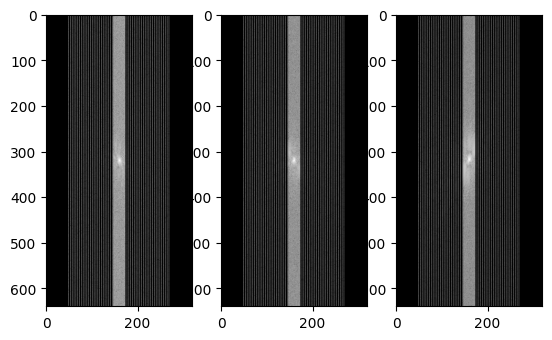

In [18]:
import fastmri

show_coils(np.log(np.abs(fastmri.complex_abs(masked_kspace).numpy()[0,:,:,:]) + 1e-9), [0, 5, 10], cmap='gray')


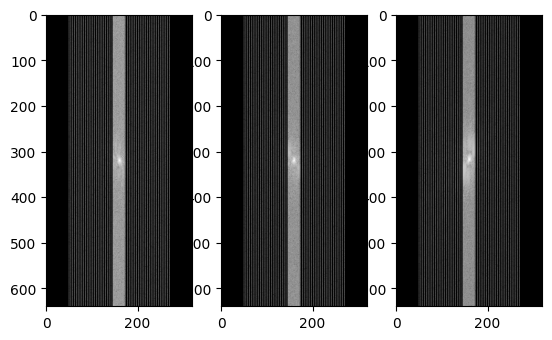

In [22]:
show_coils(np.log(np.abs(fastmri.complex_abs(masked_kspace_2).numpy()[0,:,:,:]) + 1e-9), [0, 5, 10], cmap='gray')


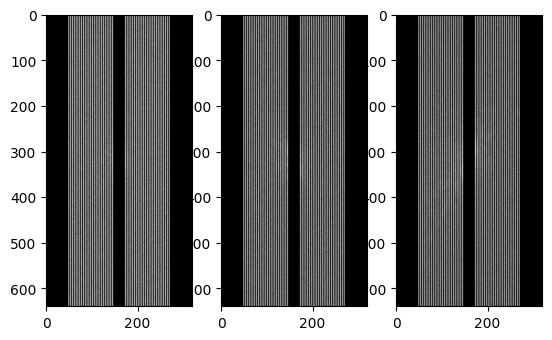

In [23]:
show_coils(np.log(np.abs(fastmri.complex_abs(masked_kspace-masked_kspace_2).numpy()[0,:,:,:]) + 1e-9), [0, 5, 10], cmap='gray')


In [24]:
(mask == mask_2).all()

tensor(False)

In [25]:
# Now, let's apply grappa

from pygrappa import grappa
import torch

def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.

    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.

    Args:
        data: Input numpy array.

    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)

def tensor_to_complex_np(data: torch.Tensor) -> np.ndarray:
    """
    Converts a complex torch tensor to numpy array.

    Args:
        data: Input data to be converted to numpy.

    Returns:
        Complex numpy version of data.
    """
    return torch.view_as_complex(data).numpy()

def apply_grappa(masked_kspace, mask):
    """
    Applies GRAPPA algorithm
    References
    ----------
    [1] Griswold, Mark A., et al. "Generalized autocalibrating
       partially parallel acquisitions (GRAPPA)." Magnetic
       Resonance in Medicine: An Official Journal of the
       International Society for Magnetic Resonance in Medicine
       47.6 (2002): 1202-1210.
    Args:
        masked_kspace (torch.Tensor): Multi-coil masked input k-space of shape (num_coils, rows, cols, 2)
        mask (torch.Tensor): Applied mask of shape (1, 1, cols, 1)
    Returns:
        preprocessed_masked_kspace (torch.Tensor): Output of GRAPPA algorithm applied on masked_kspace
    """

    def get_low_frequency_lines(mask):
        l = r = mask.shape[-2] // 2
        while mask[..., r, :]:
            r += 1

        while mask[..., l, :]:
            l -= 1

        return l + 1, r

    l, r = get_low_frequency_lines(mask)
    num_low_freqs = r - l
    pad = (mask.shape[-2] - num_low_freqs + 1) // 2
    calib = masked_kspace[:, :, pad:pad + num_low_freqs].clone()
    preprocessed_masked_kspace = grappa(tensor_to_complex_np(masked_kspace), tensor_to_complex_np(calib), kernel_size=(5, 5), coil_axis=0)
    return to_tensor(preprocessed_masked_kspace)


# Needs to be applied slice-wise
grappa_data = torch.zeros([masked_kspace.shape[0],masked_kspace.shape[1],masked_kspace.shape[2],masked_kspace.shape[3],masked_kspace.shape[4]])
for slice in range(masked_kspace.shape[0]):
    grappa_data[slice,:,:,:,:] = apply_grappa(masked_kspace[slice,:,:,:,:], mask[0,:,:,:,:])

print("Shape of the preprocessed grappa data: ", str(grappa_data.shape))


Shape of the preprocessed grappa data:  torch.Size([16, 20, 640, 320, 2])


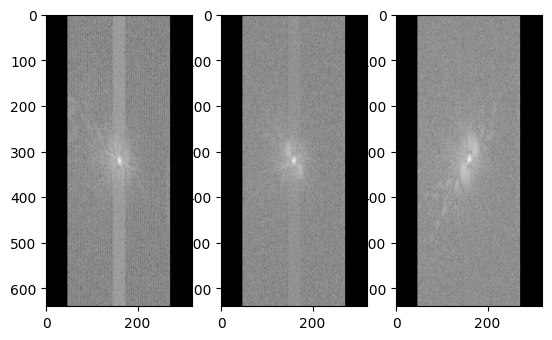

In [26]:
show_coils(np.log(np.abs(fastmri.complex_abs(grappa_data).numpy()[0,:,:,:]) + 1e-9), [0, 5, 10], cmap='gray')


In [27]:
grappa_data = tensor_to_complex_np(grappa_data)
print("Shape of the numpy-converted grappa data: ", str(grappa_data.shape))


Shape of the numpy-converted grappa data:  (16, 20, 640, 320)


In [28]:
# Add a key to the h5 file with grappa_data inside it

hf.create_dataset('grappa_data', data=grappa_data)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['grappa_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004274357358916608, 'norm': 0.09131797120370877, 'patient_id': 'dcfc3e70496246a709dab23831262b60589f4383d6e05bf5559731ea8d80bb1f'}


In [29]:
hf.close()


Here, we can test if seeding the mask for validation data works as desired

In [30]:
masked_kspace, mask, _ = T.apply_mask(kspace_torch, mask_func, seed=42)


In [35]:
masked_kspace_2, mask_2, _ = T.apply_mask(kspace_torch, mask_func, seed=42)

(mask == mask_2).all()

tensor(True)

Here, we can test our grappa preprocessing approach for test data

In [36]:
file_name = 'file_brain_AXFLAIR_200_6002441.h5'
preprocessed_train_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test'
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'a') # Open in append mode!


In [37]:
kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))
kspace_torch = T.to_tensor(kspace)
print("Shape of the torch tensor: ", str(kspace_torch.shape))


Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>
Shape of the torch tensor:  torch.Size([16, 20, 640, 320, 2])


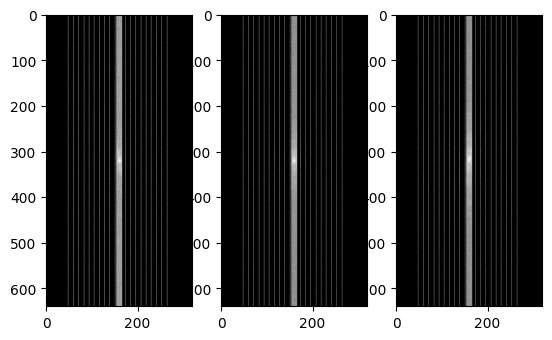

In [39]:
# Test data is already masked
show_coils(np.log(np.abs(fastmri.complex_abs(kspace_torch).numpy()[0,:,:,:]) + 1e-9), [0, 5, 10], cmap='gray')


In [47]:
# We do need to extract the mask for our grappa function though
mask = hf['mask'][()]
print("Shape of the test mask: ", str(mask.shape))
print("Datatype of the test mask: ", str(type(mask)))


Shape of the test mask:  (320,)
Datatype of the test mask:  <class 'numpy.ndarray'>


In [48]:
mask = np.expand_dims(mask, axis=-1)
print("New shape of the test mask: ", str(mask.shape))


New shape of the test mask:  (320, 1)


In [49]:
mask = np.expand_dims(mask, axis=0)
mask = np.expand_dims(mask, axis=0)
mask = np.expand_dims(mask, axis=0)
print("New shape of the test mask: ", str(mask.shape))


New shape of the test mask:  (1, 1, 1, 320, 1)


In [50]:
mask = T.to_tensor(mask)
print("New shape of the test mask: ", str(mask.shape))
print("New datatype of the test mask: ", str(type(mask)))


New shape of the test mask:  torch.Size([1, 1, 1, 320, 1])
New datatype of the test mask:  <class 'torch.Tensor'>


In [51]:
# Needs to be applied slice-wise
grappa_data = torch.zeros([kspace_torch.shape[0],kspace_torch.shape[1],kspace_torch.shape[2],kspace_torch.shape[3],kspace_torch.shape[4]])
for slice in range(kspace_torch.shape[0]):
    grappa_data[slice,:,:,:,:] = apply_grappa(kspace_torch[slice,:,:,:,:], mask[0,:,:,:,:])

print("Shape of the preprocessed grappa data: ", str(grappa_data.shape))


Shape of the preprocessed grappa data:  torch.Size([16, 20, 640, 320, 2])


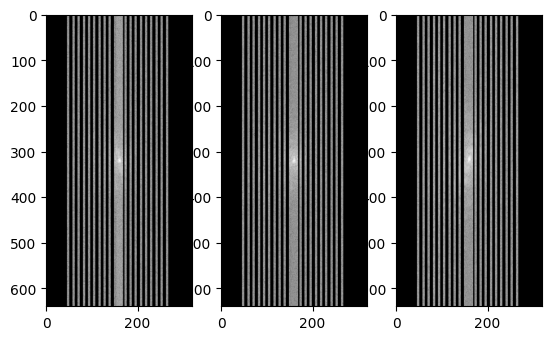

In [52]:
show_coils(np.log(np.abs(fastmri.complex_abs(grappa_data).numpy()[0,:,:,:]) + 1e-9), [0, 5, 10], cmap='gray') # Note that this scan was accelerated with R = 8


In [54]:
grappa_data = tensor_to_complex_np(grappa_data)
print("Shape of the numpy-converted grappa data: ", str(grappa_data.shape))


Shape of the numpy-converted grappa data:  (16, 20, 640, 320)


In [55]:
# Add a key to the h5 file with grappa_data inside it

hf.create_dataset('grappa_data', data=grappa_data)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['grappa_data', 'ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'AXFLAIR', 'num_low_frequency': 13, 'patient_id': 'ca18fce12f2549e69a2db3c660a4d27b116cd79c6ee2437a15db40db7379c723'}


In [56]:
hf.close()


Here, we can test a loop which loops through the files in the folders we specify

In [57]:
from pathlib import Path

folder_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/'
files = Path(folder_path).glob('**/*')
for file in files:
    print(file)


/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT1POST_203_6000790.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_209_2090032.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_205_6000143.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_202_6000578.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_200_6002431.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_209_2090309.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_209_6001383.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXT2_202_2020417.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test/file_brain_AXFLAIR_201_6002955.

Here, we can visualize the results of our GRAPPA preprocessing in the image domain

In [3]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
from fastmri.data import transforms as T


file_name = 'file_brain_AXFLAIR_200_6002425.h5'
preprocessed_train_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_train'
hf = h5py.File(os.path.join(preprocessed_train_path, file_name), 'r') # Open in read mode!

kspace = hf['kspace'][()]
print("Shape of the raw kspace: ", str(np.shape(kspace)))
print("Datatype of the raw kspace: ", str(type(kspace)))
kspace_torch = T.to_tensor(kspace)
print("Shape of the torch tensor: ", str(kspace_torch.shape))

print("")

grappa_data = hf['grappa_data'][()]
print("Shape of the raw grappa data: ", str(np.shape(grappa_data)))
print("Datatype of the raw grappa data: ", str(type(grappa_data)))
grappa_data_torch = T.to_tensor(grappa_data)
print("Shape of the torch tensor: ", str(grappa_data_torch.shape))


Shape of the raw kspace:  (16, 20, 640, 320)
Datatype of the raw kspace:  <class 'numpy.ndarray'>
Shape of the torch tensor:  torch.Size([16, 20, 640, 320, 2])

Shape of the raw grappa data:  (16, 20, 640, 320)
Datatype of the raw grappa data:  <class 'numpy.ndarray'>
Shape of the torch tensor:  torch.Size([16, 20, 640, 320, 2])


In [14]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_func = create_mask_for_mask_type('equispaced', [0.08], [4])
masked_kspace, mask, _ = T.apply_mask(kspace_torch, mask_func)


In [15]:
slice_kspace = kspace_torch[10,:,:,:,:] # Choosing the 10-th slice of this volume
slice_masked_kspace = masked_kspace[10,:,:,:,:]
slice_grappa = grappa_data_torch[10,:,:,:,:]


In [8]:
import fastmri

slice_image_T = fastmri.ifft2c(slice_kspace)
slice_image_abs = fastmri.complex_abs(slice_image_T)
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)


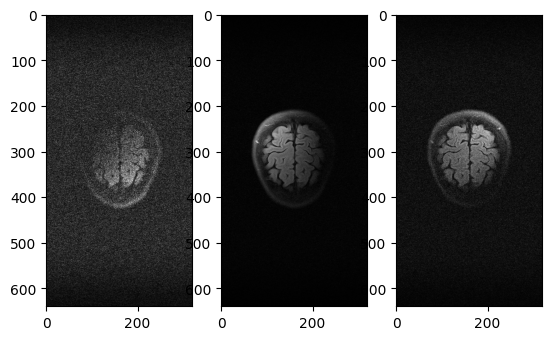

In [9]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')


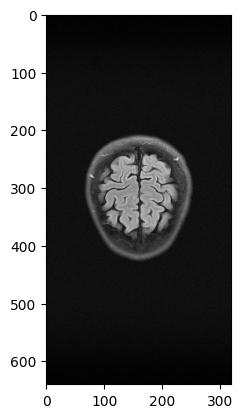

In [10]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


In [16]:
slice_zf_image_T = fastmri.ifft2c(slice_masked_kspace)
slice_zf_image_abs = fastmri.complex_abs(slice_zf_image_T)
slice_zf_image_rss = fastmri.rss(slice_zf_image_abs, dim=0)


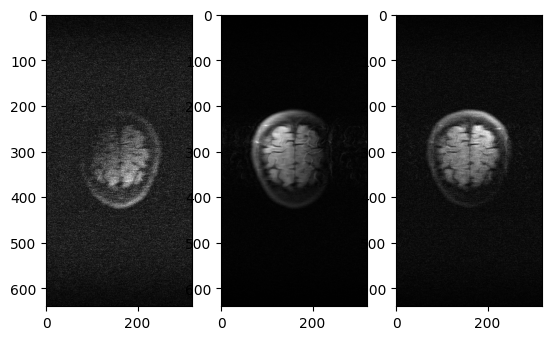

In [17]:
show_coils(slice_zf_image_abs, [0, 5, 10], cmap='gray')


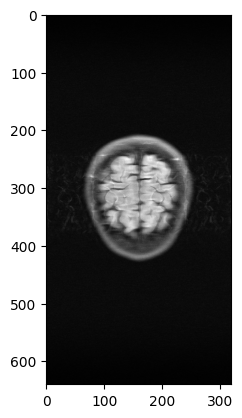

In [18]:
plt.imshow(np.abs(slice_zf_image_rss.numpy()), cmap='gray')


In [11]:
slice_grappa_image_T = fastmri.ifft2c(slice_grappa)
slice_grappa_image_abs = fastmri.complex_abs(slice_grappa_image_T)
slice_grappa_image_rss = fastmri.rss(slice_grappa_image_abs, dim=0)


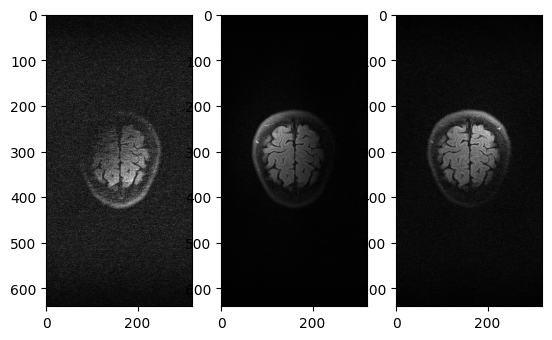

In [12]:
show_coils(slice_grappa_image_abs, [0, 5, 10], cmap='gray')


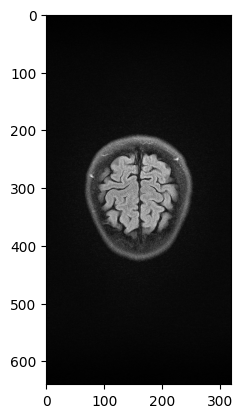

In [13]:
plt.imshow(np.abs(slice_grappa_image_rss.numpy()), cmap='gray')
